In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from util import show_status, load_batch, log_interp

In [242]:
show_status("./status.json")

Algorithm|Implemented|Status|Notes / Issues|Possible Solutions
---|---|---|---|---
CFR|✅|✅||
DeepCFR|✅|✅ (verify units)|units / metric issue?|~~try single deep paper params~~ ~~try Brown et al. params~~
ED|✅|❌|Does not converge|~~Parameter sweep from paper~~
XFP|✅|✅||
NFSP|✅|✅ (verify units)|metric issue? better than OS reported; OS inconsistent w/ Heinrich Silver|~~Try ARMAC params~~, ~~try heinrich silver params~~
RPG / RMPG|✅|✅||
QPG|✅|✅||
PSRO|✅|✅|N/A|N/A
RCFR|✅|✅|sensitive to LR, can manipulate to match OpenSpiel & waugh et al.|~~larger network~~, ~~smaller LR~~


# Figure 1
Convergence rates of XFP and ED algorithms on various partially-observable games in OpenSpiel. The units of the x-axis is iterations and the units of the y-axis is NashConv. Figure taken from [47]

### Notes:
- "We performed a sweep over the number of hidden layers (from 1 to 5), the number of hidden units (64, 128 or 256), the regularization weight (10^-7, 10^-6, 10^-5, 10^-4), and the initial learning rate (powers of 2). The plotted results show the best values from this sweep for each game."

- "We also found that the algorithm converged faster with slightly higher learning rates than the ones suggested by Section 3.3."

In [354]:
!scp -r waltomic@rci:~/openspiel_benchmarks/logs ./

rcfr_kuhn_0.csv                               100%  100    12.9KB/s   00:00    
ed_kuhn_4l_256h_r1e-7_lr1_0.csv               100%   16KB 973.7KB/s   00:00    
qpg_kuhn_8m_0.csv                             100%  228KB   2.9MB/s   00:00    
ed_kuhn_4l_128h_r1e-7_lr4_0.csv               100%   26KB   1.9MB/s   00:00    
qpg_kuhn_128_0.csv                            100%   27KB   2.1MB/s   00:00    
rpg_leduc_16m_0.csv                           100%  271KB   3.6MB/s   00:00    
exp_descent_leduc_0.csv                       100%   71    11.5KB/s   00:00    
rpg_kuhn_7.csv                                100%   26     4.3KB/s   00:00    
deep_cfr_leduc_10kbatch_reinitVF_0.csv        100%   73    11.6KB/s   00:00    
nned_0.csv                                    100%   26     4.0KB/s   00:00    
pg_8.csv                                      100%  102    16.5KB/s   00:00    
nfsp_leduc_2.csv                              100%  105KB   3.4MB/s   00:00    
ed_kuhn_2l_64h_r1e-7_lr1_0.csv          

cfr_leduc_0.csv                               100%   72    10.0KB/s   00:00    
nfsp_kuhn_0.csv                               100%  180    29.3KB/s   00:00    
ed_kuhn_t_lrdecay64_agg_0.csv                 100%   26KB   2.1MB/s   00:00    
nned_3.csv                                    100%   26     3.6KB/s   00:00    
ed_kuhn_nn_LR1_0.csv                          100%   27KB   2.4MB/s   00:00    
rpg_kuhn_12.csv                               100%   26     4.2KB/s   00:00    
exp_descent_kuhn_0.csv                        100%  601    91.3KB/s   00:00    
nfsp_kuhn_2.csv                               100%  299KB   5.2MB/s   00:00    
ed_kuhn_nn_9999_0.csv                         100%   26KB   1.9MB/s   00:00    
ed_kuhn_tabular_0.csv                         100%   27KB   2.1MB/s   00:00    
deep_cfr_kuhn_400_1.csv                       100% 6939   902.4KB/s   00:00    
ed_kuhn_5l_256h_r1e-4_lr1_0.csv               100%   26KB   2.1MB/s   00:00    
ed_kuhn_nn_LR8_0.csv                    

[Text(0.5, 0, 'Iteration'), Text(0, 0.5, 'Exploitability')]

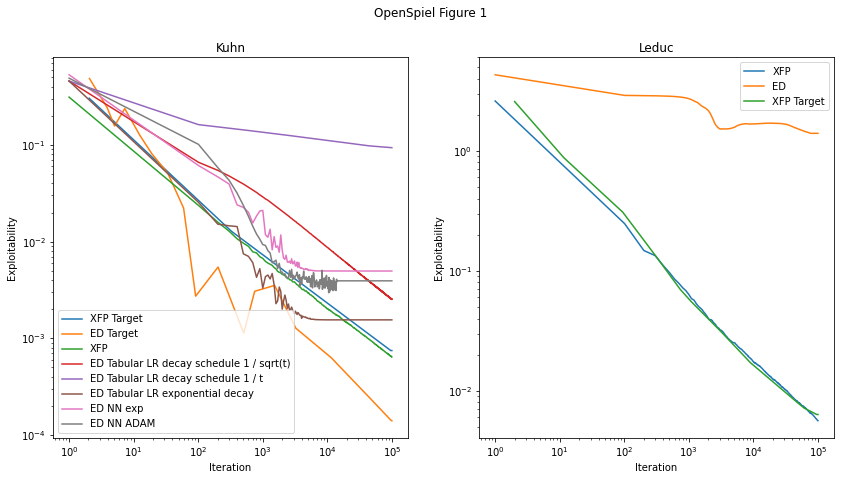

In [355]:
kuhn_logs = [("./target_results/fig1_xfp_kuhn.csv", "XFP Target"),
            ("./target_results/fig1_ed_kuhn.csv", "ED Target"),
             ("./logs/xfp_kuhn_0.csv", "XFP"),
             ("./logs/ed_kuhn_t_lrdecay_0.csv", "ED Tabular LR decay schedule 1 / sqrt(t)"),
             #("./logs/ed_kuhn_tabular_0.csv", "ED Tabular Constant LR"),
             ("./logs/ed_kuhn_t_lrdecay64_agg_0.csv", "ED Tabular LR decay schedule 1 / t"),
             ("./logs/ed_kuhn_t_lrexp_0.csv", "ED Tabular LR exponential decay"),
             #("./logs/ed_kuhn_nn_9999_0.csv", "ED NN LR exponential decay .9999"),
             #("./logs/ed_kuhn_nn_0.csv", "ED NN LR exponential decay .999"),
             #("./logs/ed_kuhn_nn_99_0.csv", "ED NN LR exponential decay"),
             #("./logs/ed_kuhn_nn_9_0.csv", "ED NN LR exponential decay .9"),
             #("./logs/ed_kuhn_nn_9_1.csv", "ED NN Constant LR"),
             #("./logs/ed_kuhn_5l_256h_r1e-4_lr1_0.csv", "ED NN LR decay schedule 1 / sqrt(t)"),
             #("./logs/ed_kuhn_nn_2l_128h_0.csv", "ED NN lr .1"),
             ("./logs/ed_kuhn_nn_lrd999_0.csv", "ED NN exp"),
             ("./logs/ed_kuhn_nn_adam_0.csv", "ED NN ADAM"),
             #("./logs/ed_kuhn_nn_2l_256h_0.csv", "ED NN 2L 256H"),
             #("./logs/ed_kuhn_nn_3l_128h_0.csv", "ED NN 3L 128H"),
             #("./logs/ed_kuhn_nn_3l_256h_0.csv", "ED NN 3L 256H"),

    #("./logs/cfr_kuhn_1.csv", "CFR"),
            #("./target_results/fig1_cfr_kuhn.csv", "CFR Target"),
            ]

leduc_logs = [#("./logs/cfr_leduc_2.csv", "CFR"),
              ("./logs/xfp_leduc_1.csv", "XFP"),
              ("./logs/exp_descent_leduc_1.csv", "ED"),
              #("./target_results/fig1_cfr_leduc.csv", "CFR Target"),
              ("./target_results/fig1_xfp_leduc.csv", "XFP Target")
            ]

kuhn_dat = load_batch(kuhn_logs, idx_offset=1)
kuhn_dat = log_interp(kuhn_dat)
leduc_dat = log_interp(load_batch(leduc_logs, idx_offset=1))

# correct for exp = NashConv / 2
#kuhn_dat["ED Target"] /= 2
#kuhn_dat["ED Tabular"] /= 2
kuhn_dat /= 2
kuhn_dat["XFP"] *= 2

#leduc_dat["CFR Target"] /= 2

#kuhn_dat["XFP Target"] /= 2
leduc_dat["XFP Target"] /= 2

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
fig.suptitle('OpenSpiel Figure 1')

ax = kuhn_dat.plot(title="Kuhn", loglog=True, ax=axes[0])
ax.set(xlabel="Iteration", ylabel="Exploitability")
#ax.set_xlim((1, 10e4))
#ax.set_ylim((10e-7, 1))

ax = leduc_dat.plot(title="Leduc", loglog=True, ax=axes[1])
ax.set(xlabel="Iteration", ylabel="Exploitability")
#ax.set_xlim((1, 10e4))
#ax.set_ylim((10e-4, 10))

# Figure 2
Convergence rate of RCFR in Leduc poker using a 2-layer network with 400 hidden units in each layer. The average policy is computed exactly (i.e. tabular), and regression targets are the
cumulative predicted regrets.

[Text(0.5, 0, 'Iteration'), Text(0, 0.5, 'Exploitability')]

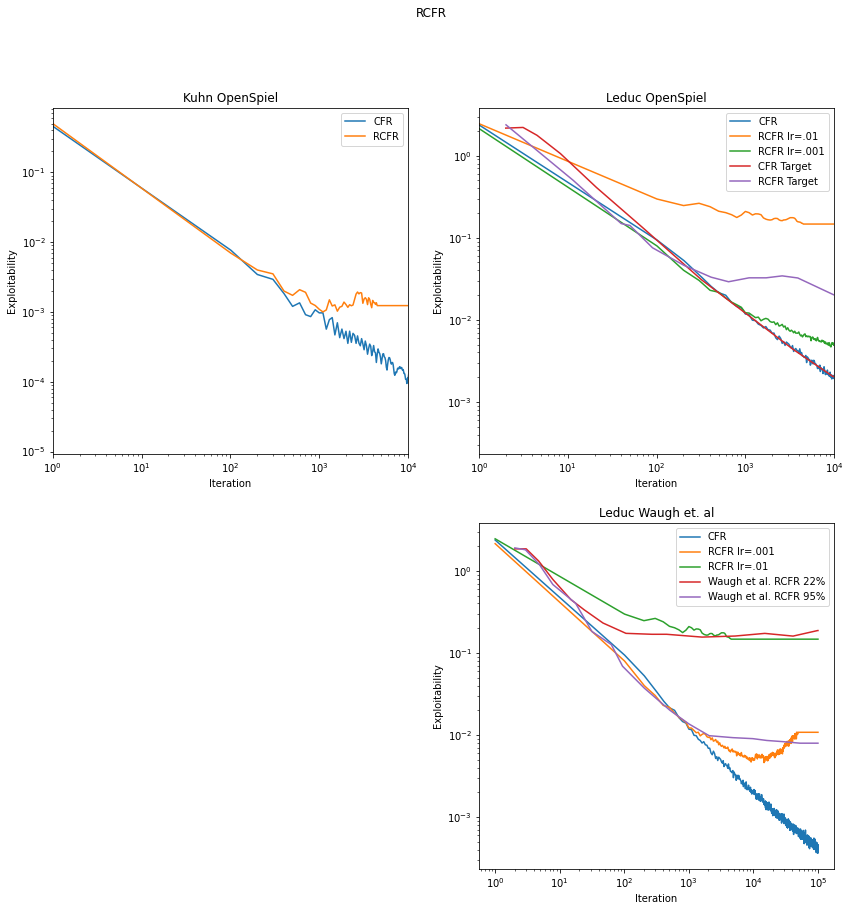

In [356]:
kuhn_logs = [("./logs/cfr_kuhn_1.csv", "CFR"),
             ("./logs/rcfr_kuhn_3.csv", "RCFR"),
            ]

leduc_logs = [("./logs/cfr_leduc_2.csv", "CFR"),
              #("./logs/rcfr_leduc_lr10-1_0.csv", "RCFR lr=.1"),
              ("./logs/rcfr_leduc_1.csv", "RCFR lr=.01"),
              ("./logs/rcfr_leduc_lr10-3_0.csv", "RCFR lr=.001"),
              ("./target_results/fig2_cfr_leduc.csv", "CFR Target"),
              ("./target_results/fig2_rcfr_leduc.csv", "RCFR Target"),
              ("./target_results/rcfr_waugh_leduc_22.csv", "Waugh et al. RCFR 22%"),
              ("./target_results/rcfr_waugh_leduc_95.csv", "Waugh et al. RCFR 95%")
            ]

kuhn_dat = log_interp(load_batch(kuhn_logs, idx_offset=1))
leduc_dat = log_interp(load_batch(leduc_logs, idx_offset=1))

# milli blind conversion, additional 1/10 scale correct for error in plot extraction
leduc_dat["Waugh et al. RCFR 22%"] *= .0001
leduc_dat["Waugh et al. RCFR 95%"] *= .0001

# nash conv -> exp
leduc_dat["CFR Target"] /= 2
leduc_dat["RCFR Target"] /= 2

log_log = True
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,14))
fig.suptitle('RCFR')
fig.delaxes(axes[1,0])

ax = kuhn_dat.plot(title="Kuhn OpenSpiel", logy=log_log, logx=log_log, ax=axes[0,0])
ax.set(xlabel="Iteration", ylabel="Exploitability")
ax.set_xlim((1, 10e3))

os_targets = ["CFR", "RCFR lr=.01", "RCFR lr=.001", "CFR Target", "RCFR Target"]
ax = leduc_dat[os_targets].plot(title="Leduc OpenSpiel", logy=log_log, logx=log_log, ax=axes[0,1])
ax.set(xlabel="Iteration", ylabel="Exploitability")
ax.set_xlim((1, 10e3))
#ax.set_ylim((10e-4, 10))

waugh_targets = ["CFR", "RCFR lr=.001", "RCFR lr=.01", "Waugh et al. RCFR 22%", "Waugh et al. RCFR 95%"]
ax = leduc_dat[waugh_targets].plot(title="Leduc Waugh et. al", logy=log_log, logx=log_log, ax=axes[1,1])
ax.set(xlabel="Iteration", ylabel="Exploitability")
#ax.set_xlim((1, 10e3))

# Figure 3
Convergence rates of NFSP and various (regret-based) policy gradient algorithms in 2-player Leduc poker. Each line is an __average over the top five seeds and hyperparemeter settings for each algorithm__. The lowest (around 0.2) exploitability value reached by any individual run is depicted by a dashed line.

In [217]:
leduc_dat.tail()

,NFSP OS default,ARMAC params e .06 rl_lr .001 sl_lr .001,OS params 4 layer 128,OpenSpiel Target,Heinrich Silver 16,Heinrich Silver 128,ARMAC Target,UGTAMARL
iteration,,,,,,,,
36510001.0,0.104524,0.13259,0.148556,0.334332,0.450789,0.121033,0.09,0.415905
36520001.0,0.103217,0.13259,0.148556,0.334332,0.450789,0.121033,0.09,0.415905
36530001.0,0.110038,0.13259,0.148556,0.334332,0.450789,0.121033,0.09,0.415905
36540001.0,0.106776,0.13259,0.148556,0.334332,0.450789,0.121033,0.09,0.415905
36550001.0,0.109048,0.13259,0.148556,0.334332,0.450789,0.121033,0.09,0.415905


In [229]:
leduc_dat.tail()

,NFSP OS default,ARMAC params e .06 rl_lr .001 sl_lr .001,OpenSpiel Target,Heinrich Silver 16,Heinrich Silver 128,ARMAC Target,UGTAMARL
iteration,,,,,,,
36510001.0,0.104524,0.13259,0.334332,0.450789,0.121033,0.09,0.415905
36520001.0,0.103217,0.13259,0.334332,0.450789,0.121033,0.09,0.415905
36530001.0,0.110038,0.13259,0.334332,0.450789,0.121033,0.09,0.415905
36540001.0,0.106776,0.13259,0.334332,0.450789,0.121033,0.09,0.415905
36550001.0,0.109048,0.13259,0.334332,0.450789,0.121033,0.09,0.415905


(10000.0, 3000000)

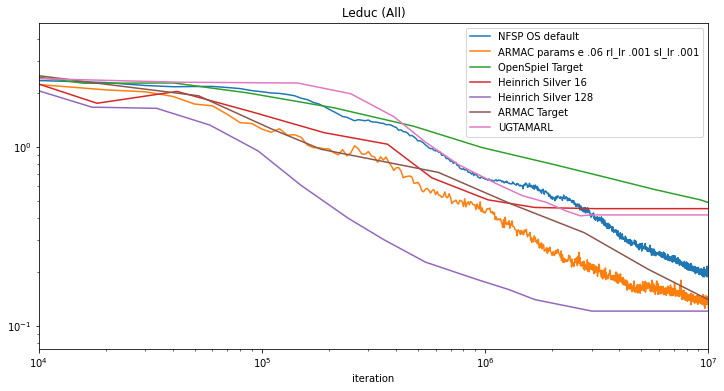

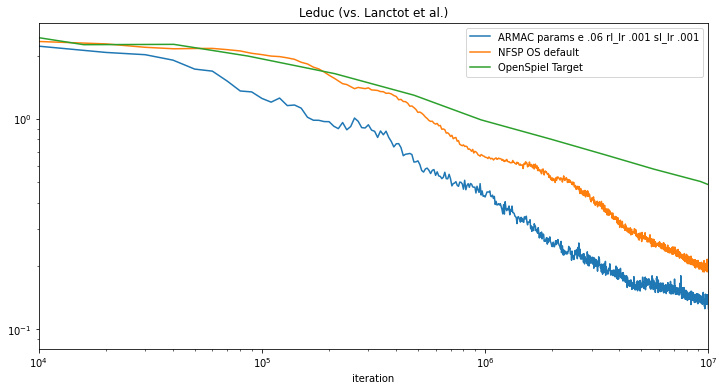

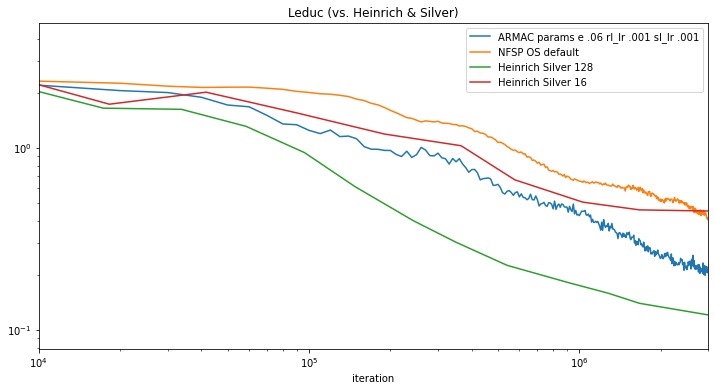

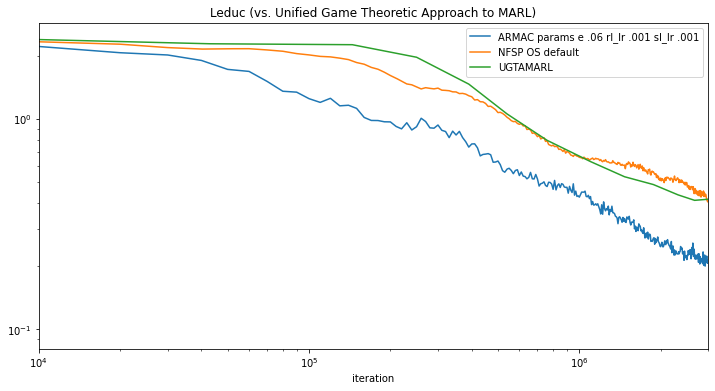

In [243]:
leduc_logs = [#("./logs/nfsp_leduc_orig_128_0.csv", "NFSP 128"),
              #("./logs/nfsp_leduc_orig_16_0.csv", "NFSP 16"),
              ("./logs/nfsp_leduc_2.csv", "NFSP OS default"),
              #("./logs/nfsp_leduc_armac_e06_rl-1_sl-2_1.csv", "ARMAC params rl_lr .1 sl_lr .01"),
              #("./logs/nfsp_leduc_armac_e06_rl-2_sl-3_1.csv", "ARMAC params rl_lr .01 sl_lr .001"),
                ("./logs/nfsp_leduc_armac_e06_rl-3_sl-3_0.csv", "ARMAC params e .06 rl_lr .001 sl_lr .001"),
                #("./logs/nfsp_leduc_armac_e24_rl-3_sl-3_0.csv", "ARMAC params e .24 rl_lr .001 sl_lr .001"),
                #("./logs/nfsp_leduc_osdeep_0.csv", "OS params 4 layer 128"),
              ("target_results/fig3_nfsp_leduc.csv", "OpenSpiel Target"),
              ("target_results/nfsp_heinrich_silver_16.csv", "Heinrich Silver 16"),
              ("target_results/nfsp_heinrich_silver_leduc_128.csv", "Heinrich Silver 128"),
    ("target_results/nfsp_ARMAC_leduc.csv", "ARMAC Target"),
    ("./target_results/nfsp_ugtamarl_leduc.csv", "UGTAMARL")
            ]

leduc_dat = log_interp(load_batch(leduc_logs, idx_offset=1))

leduc_dat["UGTAMARL"] /= 2
leduc_dat["ARMAC Target"] /= 2
leduc_dat["Heinrich Silver 128"] *= 2
leduc_dat["Heinrich Silver 16"] *=2

ax = leduc_dat.plot(title="Leduc (All)", loglog=True, figsize=(12,6))
#ax.set_ylim((.05, 5))
ax.set_xlim((1e4, 1e7))

select = ["ARMAC params e .06 rl_lr .001 sl_lr .001",
          "NFSP OS default",
          "OpenSpiel Target"
         ]
ax = leduc_dat[select].plot(title="Leduc (vs. Lanctot et al.)", loglog=True, figsize=(12,6))
#ax.set_ylim((.05, 5))
ax.set_xlim((1e4, 1e7))

select = ["ARMAC params e .06 rl_lr .001 sl_lr .001",
          "NFSP OS default",
          "Heinrich Silver 128",
          "Heinrich Silver 16"
         ]
ax = leduc_dat[select].plot(title="Leduc (vs. Heinrich & Silver)", loglog=True, figsize=(12,6))
#ax.set_ylim((.05, 5))
ax.set_xlim((1e4, 3000000))

select = ["ARMAC params e .06 rl_lr .001 sl_lr .001",
          "NFSP OS default",
          "UGTAMARL"
         ]
ax = leduc_dat[select].plot(title="Leduc (vs. Unified Game Theoretic Approach to MARL)", loglog=True, figsize=(12,6))
#ax.set_ylim((.05, 5))
ax.set_xlim((1e4, 3000000))

# RMPG / RPG & QPG

Text(0.5, 0.98, 'Policy Gradient')

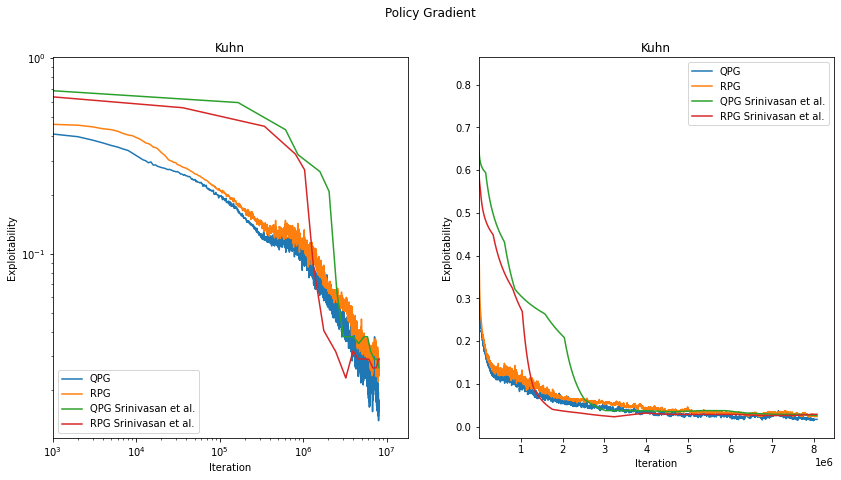

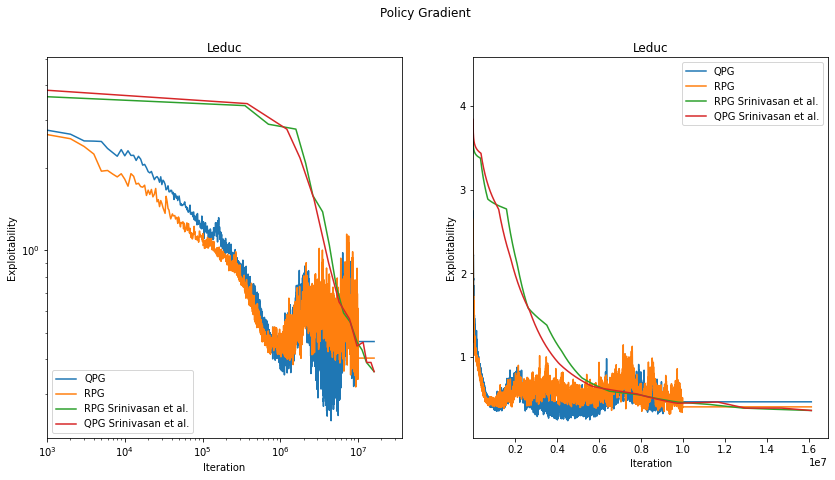

In [349]:
kuhn_logs = [#("./logs/qpg_kuhn_128_0.csv", "QPG 1 layer"),
             ("./logs/qpg_kuhn_8m_0.csv", "QPG"),
             #("./logs/rpg_kuhn_128_0.csv", "RPG 1 layer"),
             ("./logs/rpg_kuhn_8m_0.csv", "RPG"),
             ("./target_results/qpg_srinivasan_kuhn.csv", "QPG Srinivasan et al."),
             ("./target_results/rpg_srinivasan_kuhn.csv", "RPG Srinivasan et al.")
            ]

leduc_logs = [#("./logs/qpg_leduc_128_0.csv", "QPG 1 layer"),
             ("./logs/qpg_leduc_16m_0.csv", "QPG"),
             #("./logs/rpg_leduc_128_1.csv", "RPG 1 layer"),
             ("./logs/rpg_leduc_16m_0.csv", "RPG"),
              ("./target_results/rpg_srinivasan_leduc.csv", "RPG Srinivasan et al."),
              ("./target_results/qpg_srinivasan_leduc.csv", "QPG Srinivasan et al.")
            ]

kuhn_dat = log_interp(load_batch(kuhn_logs, idx_offset=1))
leduc_dat = log_interp(load_batch(leduc_logs, idx_offset=1))

# kuhn_dat["QPG Srinivasan et al."] /= 2
# kuhn_dat["RPG Srinivasan et al."] /= 2
# leduc_dat["RPG Srinivasan et al."] /= 2
# leduc_dat["QPG Srinivasan et al."] /= 2


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
ax = kuhn_dat.plot(title="Kuhn", loglog=True, ax=axes[0])
ax.set(xlabel="Iteration", ylabel="Exploitability")
ax.set_xlim((1000))

ax = kuhn_dat.plot(title="Kuhn", loglog=False, ax=axes[1])
ax.set(xlabel="Iteration", ylabel="Exploitability")
ax.set_xlim((1000))
fig.suptitle('Policy Gradient')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
ax = leduc_dat.plot(title="Leduc", loglog=True, ax=axes[0])
ax.set(xlabel="Iteration", ylabel="Exploitability")
ax.set_xlim((1000))

ax = leduc_dat.plot(title="Leduc", loglog=False, ax=axes[1])
ax.set(xlabel="Iteration", ylabel="Exploitability")
ax.set_xlim((1000))
fig.suptitle('Policy Gradient')

# DeepCFR

In [214]:
leduc_dat.tail()

,DeepCFR,DeepCFR Target
iteration,,
11000.0,0.500682,0.790114
11100.0,0.492417,0.790114
11200.0,0.504237,0.790114
11300.0,0.506757,0.790114
11400.0,0.493390,0.790114


Text(0.5, 0.98, 'DeepCFR')

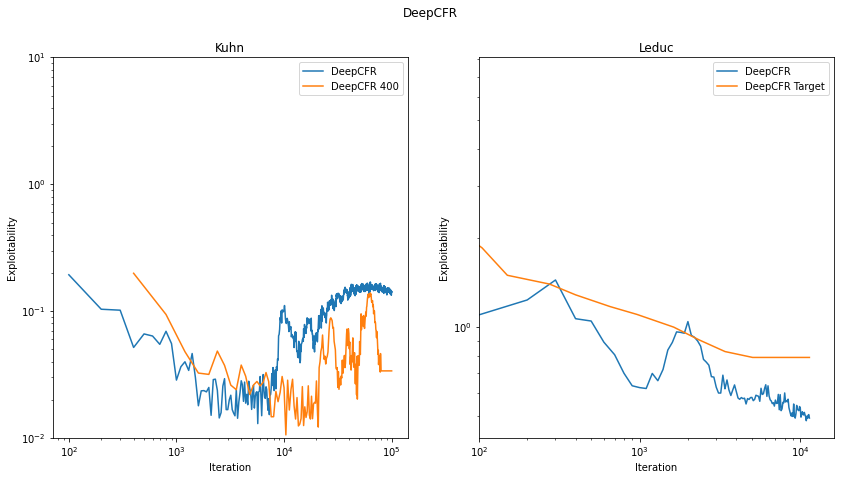

In [359]:
kuhn_logs = [("./logs/deep_cfr_kuhn_0.csv", "DeepCFR"),
             ("./logs/deep_cfr_kuhn_400_0.csv", "DeepCFR 400"),
            ]

leduc_logs = [("./logs/deep_cfr_leduc_4.csv", "DeepCFR"),
              #("./logs/deep_cfr_leduc_400_0.csv", "DeepCFR 400"),
              ("./target_results/deepcfr_singledeep_leduc.csv", "DeepCFR Target")
            ]

kuhn_dat = log_interp(load_batch(kuhn_logs))
leduc_dat = log_interp(load_batch(leduc_logs))

leduc_dat["DeepCFR"] /= 2
#leduc_dat["DeepCFR 400"] /= 2
leduc_dat["DeepCFR Target"] /= 100

log_log = True
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
ax = kuhn_dat.plot(title="Kuhn", logy=log_log, logx=log_log, ax=axes[0])
ax.set(xlabel="Iteration", ylabel="Exploitability")
ax.set_ylim((.01, 10))
ax = leduc_dat.plot(title="Leduc", loglog=True, ax=axes[1])
ax.set(xlabel="Iteration", ylabel="Exploitability")
#ax.set_ylim((.01, 10))
ax.set_xlim((100))
fig.suptitle('DeepCFR')

# PSRO

Text(0.5, 0.98, 'PSRO')

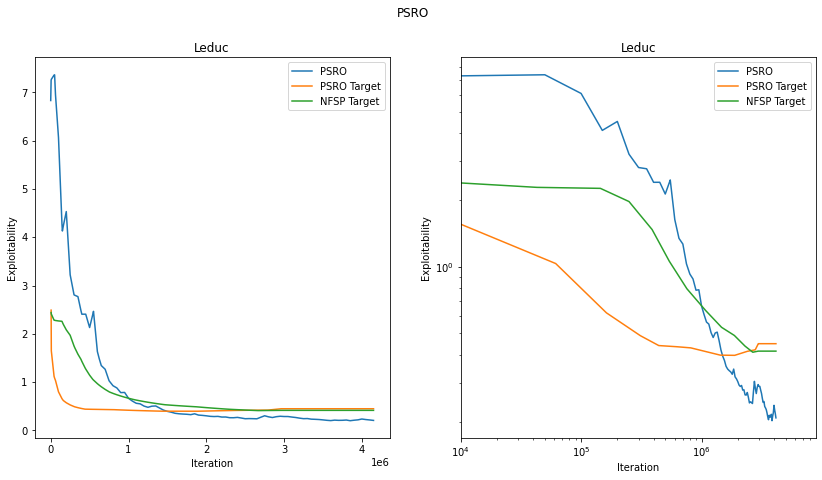

In [244]:
kuhn_logs = [("./logs/psro_kuhn_0.csv", "PSRO"),
            ]

leduc_logs = [#("./logs/psro_2.csv", "PSRO Short Run"),
             ("./logs/psro_3.csv", "PSRO"),
              ("./target_results/psro_ugtamarl_leduc.csv", "PSRO Target"),
             ("./target_results/nfsp_ugtamarl_leduc.csv", "NFSP Target"),
            ]

kuhn_dat = log_interp(load_batch(kuhn_logs, idx_offset=1))
leduc_dat = log_interp(load_batch(leduc_logs, idx_offset=1))

leduc_dat["PSRO Target"] /= 2
leduc_dat["NFSP Target"] /= 2
#leduc_dat /= 2

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
ax = leduc_dat.plot(title="Leduc", loglog=False, ax=axes[0])
ax.set(xlabel="Iteration", ylabel="Exploitability")

ax = leduc_dat.plot(title="Leduc", loglog=True, ax=axes[1])
ax.set(xlabel="Iteration", ylabel="Exploitability")
ax.set_xlim((10000))
fig.suptitle('PSRO')